In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.nn import functional as F

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

In [103]:
def FMNIST_dataset():
    train_data = FashionMNIST(root='data', train=True, download=True, transform=ToTensor())
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

    test_data = FashionMNIST(root='data', train=False, download=True, transform=ToTensor())
    test_loader = DataLoader(test_data, batch_size=64, shuffle=True)
    return train_loader, test_loader


def CIFAR10_dataset():
    # CIFAR-10 데이터셋 다운로드
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])
    train_set = datasets.CIFAR10(root='./data', train=True,
                                download=True, transform=transform)
    test_set = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=transform)
    # 데이터로더 생성
    batch_size = 64
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
    return train_loader, test_loader



def Run(dataset, model, optimizer, criterion, EPOCHS):
    if dataset == 'CIFAR-10': train_loader, test_loader = CIFAR10_dataset()
    elif dataset == 'FMNIST': train_loader, test_loader = FMNIST_dataset()
    
    train_acc_list = []
    test_acc_list = []
    train_loss_list = []
    test_loss_list = []
    for epoch in range(EPOCHS):
        # Train
        train_loss = 0
        train_correct = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data, epoch)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (output.argmax(1) == target).sum().item()
        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)
        train_acc_list.append(train_accuracy)
        train_loss_list.append(train_loss)
        
        # Test
        test_loss = 0
        test_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data, epoch)
                loss = criterion(output, target)
                test_loss += loss.item()
                test_correct += (output.argmax(1) == target).sum().item()
            test_loss /= len(test_loader.dataset)
            test_accuracy = test_correct / len(test_loader.dataset)
            test_acc_list.append(test_accuracy)
            test_loss_list.append(test_loss)
        
        # Show Result
        print(f'Epoch {epoch + 1:2d} | '
            f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | '
            f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}')
    return train_loss_list, train_acc_list, test_loss_list, test_acc_list


def plot(method, dataset, exp_num, epochs, train_loss_list, train_acc_list, test_loss_list, test_acc_list, save=False):
    figname = f'{method} ({dataset}) #{exp_num} E:{epochs}.png'
    plt.figure(figsize=(10, 6), dpi=1000)
    plt.plot(train_acc_list, label='Train_acc')
    plt.plot(test_acc_list, label='Test_acc')
    plt.plot(train_loss_list, label='Train_loss')
    plt.plot(test_loss_list, label='Test_loss')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    if save: plt.savefig(figname)
    plt.show()

In [104]:
# Epsilon Dropout Method
def lowdrop(x, e):
    y = x-e
    return y

def highdrop(x, e):
    y = -1 * (x-(1-e))
    return y

class EDrop(nn.Module):
    def __init__(self, e=0.5, switch=999999):
        super(EDrop, self).__init__()
        self.e = e
        self.switch = switch
        self.lowdrop = lowdrop
        self.highdrop = highdrop
        
    def forward(self, x, curr_epoch):
        if not self.training: return x
        
        if curr_epoch < self.switch    :  return x-self.e
        elif self.switch <= curr_epoch :  return -1 * (x-(1-self.e))

In [105]:
# small big small big small
def Jumping_Edrop(x, e, curr_epoch, switch):
    if curr_epoch < 20:
        return lowdrop(x, e)
    elif 40 > curr_epoch >= 20:
        return highdrop(x, e)
    elif 60 > curr_epoch >= 40:
        return lowdrop(x, e)
    elif 80 > curr_epoch >= 60:
        return highdrop(x, e)
    elif  curr_epoch >= 80:
        return lowdrop(x, e)

In [106]:
class Net_FMNIST(nn.Module):
    def __init__(self, epsilon, switch):
        super().__init__()
        # Layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.edrop1 = EDrop(epsilon, switch)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.edrop2 = EDrop(epsilon, switch)
        
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.edrop3 = EDrop(epsilon, switch)

        self.fc2 = nn.Linear(128, 10)

        self.jedrop = Jumping_Edrop


    def forward(self, x, curr_epoch):
        # [64, 1, 28, 28]

        x = self.conv1(x)     
        x = self.bn1(x)       
        x = self.edrop1(x, curr_epoch) 
        x = F.relu(x)          
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)     
        x = self.bn2(x)       
        x = self.edrop2(x, curr_epoch) 
        x = F.relu(x)         
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 32 * 7 * 7)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.edrop3(x, curr_epoch)
        x = F.relu(x)
        
        x = self.fc2(x)
        return x
    

In [107]:
# Run (FMNIST)
dataset = 'FMNIST'
FMNIST_EPOCHS = 0
FMNIST_EPSILON = 0.5
FMNIST_SWITCH = FMNIST_EPOCHS/2

model = Net_FMNIST(FMNIST_EPSILON, FMNIST_SWITCH).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(dataset, model, optimizer, criterion, FMNIST_EPOCHS, FMNIST_EPSILON, FMNIST_SWITCH)


In [108]:
# Results

# 1st Run
# Epoch  1 | Train Loss: 0.0057 | Train Accuracy: 0.8799 | Test Loss: 0.0044 | Test Accuracy: 0.8973
# Epoch  2 | Train Loss: 0.0035 | Train Accuracy: 0.9178 | Test Loss: 0.0040 | Test Accuracy: 0.9063
# Epoch  3 | Train Loss: 0.0029 | Train Accuracy: 0.9307 | Test Loss: 0.0037 | Test Accuracy: 0.9134
# Epoch  4 | Train Loss: 0.0025 | Train Accuracy: 0.9420 | Test Loss: 0.0037 | Test Accuracy: 0.9173
# Epoch  5 | Train Loss: 0.0021 | Train Accuracy: 0.9519 | Test Loss: 0.0038 | Test Accuracy: 0.9195
# Epoch  6 | Train Loss: 0.0017 | Train Accuracy: 0.9597 | Test Loss: 0.0039 | Test Accuracy: 0.9158
# Epoch  7 | Train Loss: 0.0015 | Train Accuracy: 0.9667 | Test Loss: 0.0039 | Test Accuracy: 0.9193
# Epoch  8 | Train Loss: 0.0013 | Train Accuracy: 0.9704 | Test Loss: 0.0044 | Test Accuracy: 0.9153
# Epoch  9 | Train Loss: 0.0010 | Train Accuracy: 0.9757 | Test Loss: 0.0043 | Test Accuracy: 0.9183
# Epoch 10 | Train Loss: 0.0008 | Train Accuracy: 0.9815 | Test Loss: 0.0048 | Test Accuracy: 0.9120

# 2nd Run
# Epoch  1 | Train Loss: 0.0058 | Train Accuracy: 0.8755 | Test Loss: 0.0046 | Test Accuracy: 0.8927
# Epoch  2 | Train Loss: 0.0036 | Train Accuracy: 0.9164 | Test Loss: 0.0042 | Test Accuracy: 0.9011
# Epoch  3 | Train Loss: 0.0030 | Train Accuracy: 0.9304 | Test Loss: 0.0040 | Test Accuracy: 0.9075
# Epoch  4 | Train Loss: 0.0025 | Train Accuracy: 0.9414 | Test Loss: 0.0041 | Test Accuracy: 0.9067
# Epoch  5 | Train Loss: 0.0021 | Train Accuracy: 0.9512 | Test Loss: 0.0039 | Test Accuracy: 0.9146
# Epoch  6 | Train Loss: 0.0018 | Train Accuracy: 0.9585 | Test Loss: 0.0041 | Test Accuracy: 0.9108
# Epoch  7 | Train Loss: 0.0015 | Train Accuracy: 0.9651 | Test Loss: 0.0041 | Test Accuracy: 0.9158
# Epoch  8 | Train Loss: 0.0013 | Train Accuracy: 0.9702 | Test Loss: 0.0045 | Test Accuracy: 0.9084
# Epoch  9 | Train Loss: 0.0011 | Train Accuracy: 0.9753 | Test Loss: 0.0046 | Test Accuracy: 0.9112
# Epoch 10 | Train Loss: 0.0009 | Train Accuracy: 0.9796 | Test Loss: 0.0051 | Test Accuracy: 0.9111

# # 3rd Run (Bigdrop)
# Epoch  1 | Train Loss: 0.0054 | Train Accuracy: 0.8781 | Test Loss: 0.0045 | Test Accuracy: 0.8949
# Epoch  2 | Train Loss: 0.0037 | Train Accuracy: 0.9134 | Test Loss: 0.0041 | Test Accuracy: 0.9044
# Epoch  3 | Train Loss: 0.0031 | Train Accuracy: 0.9262 | Test Loss: 0.0038 | Test Accuracy: 0.9140
# Epoch  4 | Train Loss: 0.0027 | Train Accuracy: 0.9378 | Test Loss: 0.0037 | Test Accuracy: 0.9134
# Epoch  5 | Train Loss: 0.0023 | Train Accuracy: 0.9466 | Test Loss: 0.0040 | Test Accuracy: 0.9124
# Epoch  6 | Train Loss: 0.0020 | Train Accuracy: 0.9542 | Test Loss: 0.0040 | Test Accuracy: 0.9153
# Epoch  7 | Train Loss: 0.0017 | Train Accuracy: 0.9622 | Test Loss: 0.0043 | Test Accuracy: 0.9130
# Epoch  8 | Train Loss: 0.0014 | Train Accuracy: 0.9681 | Test Loss: 0.0043 | Test Accuracy: 0.9115
# Epoch  9 | Train Loss: 0.0012 | Train Accuracy: 0.9735 | Test Loss: 0.0049 | Test Accuracy: 0.9041
# Epoch 10 | Train Loss: 0.0010 | Train Accuracy: 0.9774 | Test Loss: 0.0048 | Test Accuracy: 0.9120

# 4th Run (high low high low high)
# Epoch  1 | Train Loss: 0.0056 | Train Accuracy: 0.8731 | Test Loss: 0.0049 | Test Accuracy: 0.8872
# Epoch  2 | Train Loss: 0.0039 | Train Accuracy: 0.9095 | Test Loss: 0.0044 | Test Accuracy: 0.8998
# Epoch  3 | Train Loss: 0.0033 | Train Accuracy: 0.9235 | Test Loss: 0.0041 | Test Accuracy: 0.9064
# Epoch  4 | Train Loss: 0.0029 | Train Accuracy: 0.9327 | Test Loss: 0.0039 | Test Accuracy: 0.9128
# Epoch  5 | Train Loss: 0.0025 | Train Accuracy: 0.9411 | Test Loss: 0.0039 | Test Accuracy: 0.9137
# Epoch  6 | Train Loss: 0.0021 | Train Accuracy: 0.9497 | Test Loss: 0.0041 | Test Accuracy: 0.9153
# Epoch  7 | Train Loss: 0.0019 | Train Accuracy: 0.9547 | Test Loss: 0.0040 | Test Accuracy: 0.9177
# Epoch  8 | Train Loss: 0.0016 | Train Accuracy: 0.9637 | Test Loss: 0.0044 | Test Accuracy: 0.9131
# Epoch  9 | Train Loss: 0.0014 | Train Accuracy: 0.9674 | Test Loss: 0.0047 | Test Accuracy: 0.9056
# Epoch 10 | Train Loss: 0.0012 | Train Accuracy: 0.9729 | Test Loss: 0.0045 | Test Accuracy: 0.9139
# Epoch 11 | Train Loss: 0.0010 | Train Accuracy: 0.9767 | Test Loss: 0.0049 | Test Accuracy: 0.9166
# Epoch 12 | Train Loss: 0.0009 | Train Accuracy: 0.9795 | Test Loss: 0.0053 | Test Accuracy: 0.9086
# Epoch 13 | Train Loss: 0.0008 | Train Accuracy: 0.9820 | Test Loss: 0.0053 | Test Accuracy: 0.9133
# Epoch 14 | Train Loss: 0.0007 | Train Accuracy: 0.9839 | Test Loss: 0.0055 | Test Accuracy: 0.9121
# Epoch 15 | Train Loss: 0.0006 | Train Accuracy: 0.9860 | Test Loss: 0.0056 | Test Accuracy: 0.9113
# Epoch 16 | Train Loss: 0.0005 | Train Accuracy: 0.9880 | Test Loss: 0.0062 | Test Accuracy: 0.9043
# Epoch 17 | Train Loss: 0.0005 | Train Accuracy: 0.9895 | Test Loss: 0.0059 | Test Accuracy: 0.9105
# Epoch 18 | Train Loss: 0.0004 | Train Accuracy: 0.9904 | Test Loss: 0.0062 | Test Accuracy: 0.9111
# Epoch 19 | Train Loss: 0.0004 | Train Accuracy: 0.9908 | Test Loss: 0.0064 | Test Accuracy: 0.9115
# Epoch 20 | Train Loss: 0.0004 | Train Accuracy: 0.9911 | Test Loss: 0.0064 | Test Accuracy: 0.9127
# Epoch 21 | Train Loss: 0.0065 | Train Accuracy: 0.8650 | Test Loss: 0.0047 | Test Accuracy: 0.8906
# Epoch 22 | Train Loss: 0.0040 | Train Accuracy: 0.9076 | Test Loss: 0.0044 | Test Accuracy: 0.8997
# Epoch 23 | Train Loss: 0.0034 | Train Accuracy: 0.9207 | Test Loss: 0.0042 | Test Accuracy: 0.9044
# Epoch 24 | Train Loss: 0.0030 | Train Accuracy: 0.9310 | Test Loss: 0.0040 | Test Accuracy: 0.9082
# Epoch 25 | Train Loss: 0.0025 | Train Accuracy: 0.9415 | Test Loss: 0.0041 | Test Accuracy: 0.9091
# ...
# Epoch 29 | Train Loss: 0.0014 | Train Accuracy: 0.9669 | Test Loss: 0.0046 | Test Accuracy: 0.9163
# Epoch 30 | Train Loss: 0.0013 | Train Accuracy: 0.9709 | Test Loss: 0.0047 | Test Accuracy: 0.9122
# Epoch 31 | Train Loss: 0.0011 | Train Accuracy: 0.9753 | Test Loss: 0.0051 | Test Accuracy: 0.9140
# Epoch 32 | Train Loss: 0.0010 | Train Accuracy: 0.9775 | Test Loss: 0.0052 | Test Accuracy: 0.9116

# 5th Run (low high low high low)
# Epoch  1 | Train Loss: 0.0055 | Train Accuracy: 0.8789 | Test Loss: 0.0045 | Test Accuracy: 0.8970
# Epoch  2 | Train Loss: 0.0035 | Train Accuracy: 0.9174 | Test Loss: 0.0040 | Test Accuracy: 0.9075
# Epoch  3 | Train Loss: 0.0029 | Train Accuracy: 0.9300 | Test Loss: 0.0039 | Test Accuracy: 0.9129
# Epoch  4 | Train Loss: 0.0025 | Train Accuracy: 0.9410 | Test Loss: 0.0040 | Test Accuracy: 0.9083
# Epoch  5 | Train Loss: 0.0021 | Train Accuracy: 0.9510 | Test Loss: 0.0039 | Test Accuracy: 0.9140
# Epoch  6 | Train Loss: 0.0018 | Train Accuracy: 0.9585 | Test Loss: 0.0043 | Test Accuracy: 0.9083
# Epoch  7 | Train Loss: 0.0014 | Train Accuracy: 0.9666 | Test Loss: 0.0045 | Test Accuracy: 0.9107
# Epoch  8 | Train Loss: 0.0012 | Train Accuracy: 0.9724 | Test Loss: 0.0047 | Test Accuracy: 0.9091
# Epoch  9 | Train Loss: 0.0010 | Train Accuracy: 0.9767 | Test Loss: 0.0049 | Test Accuracy: 0.9115
# Epoch 10 | Train Loss: 0.0008 | Train Accuracy: 0.9810 | Test Loss: 0.0049 | Test Accuracy: 0.9145
# Epoch 11 | Train Loss: 0.0007 | Train Accuracy: 0.9845 | Test Loss: 0.0054 | Test Accuracy: 0.9068
# Epoch 12 | Train Loss: 0.0006 | Train Accuracy: 0.9866 | Test Loss: 0.0054 | Test Accuracy: 0.9170
# Epoch 13 | Train Loss: 0.0005 | Train Accuracy: 0.9887 | Test Loss: 0.0057 | Test Accuracy: 0.9112
# Epoch 14 | Train Loss: 0.0005 | Train Accuracy: 0.9891 | Test Loss: 0.0059 | Test Accuracy: 0.9138
# Epoch 15 | Train Loss: 0.0004 | Train Accuracy: 0.9909 | Test Loss: 0.0061 | Test Accuracy: 0.9112
# Epoch 16 | Train Loss: 0.0004 | Train Accuracy: 0.9918 | Test Loss: 0.0063 | Test Accuracy: 0.9072
# Epoch 17 | Train Loss: 0.0004 | Train Accuracy: 0.9925 | Test Loss: 0.0069 | Test Accuracy: 0.9054
# Epoch 18 | Train Loss: 0.0004 | Train Accuracy: 0.9917 | Test Loss: 0.0067 | Test Accuracy: 0.9070
# Epoch 19 | Train Loss: 0.0003 | Train Accuracy: 0.9939 | Test Loss: 0.0066 | Test Accuracy: 0.9142
# Epoch 20 | Train Loss: 0.0003 | Train Accuracy: 0.9933 | Test Loss: 0.0067 | Test Accuracy: 0.9108
# Epoch 21 | Train Loss: 0.0079 | Train Accuracy: 0.8529 | Test Loss: 0.0057 | Test Accuracy: 0.8755
# Epoch 22 | Train Loss: 0.0047 | Train Accuracy: 0.8922 | Test Loss: 0.0051 | Test Accuracy: 0.8903
# Epoch 23 | Train Loss: 0.0041 | Train Accuracy: 0.9048 | Test Loss: 0.0048 | Test Accuracy: 0.8939
# Epoch 24 | Train Loss: 0.0037 | Train Accuracy: 0.9147 | Test Loss: 0.0047 | Test Accuracy: 0.8961
# Epoch 25 | Train Loss: 0.0033 | Train Accuracy: 0.9232 | Test Loss: 0.0046 | Test Accuracy: 0.8993
# ...
# Epoch 97 | Train Loss: 0.0001 | Train Accuracy: 0.9980 | Test Loss: 0.0085 | Test Accuracy: 0.9146
# Epoch 98 | Train Loss: 0.0001 | Train Accuracy: 0.9973 | Test Loss: 0.0090 | Test Accuracy: 0.9146
# Epoch 99 | Train Loss: 0.0001 | Train Accuracy: 0.9967 | Test Loss: 0.0088 | Test Accuracy: 0.9146
# Epoch 100 | Train Loss: 0.0001 | Train Accuracy: 0.9978 | Test Loss: 0.0096 | Test Accuracy: 0.9110

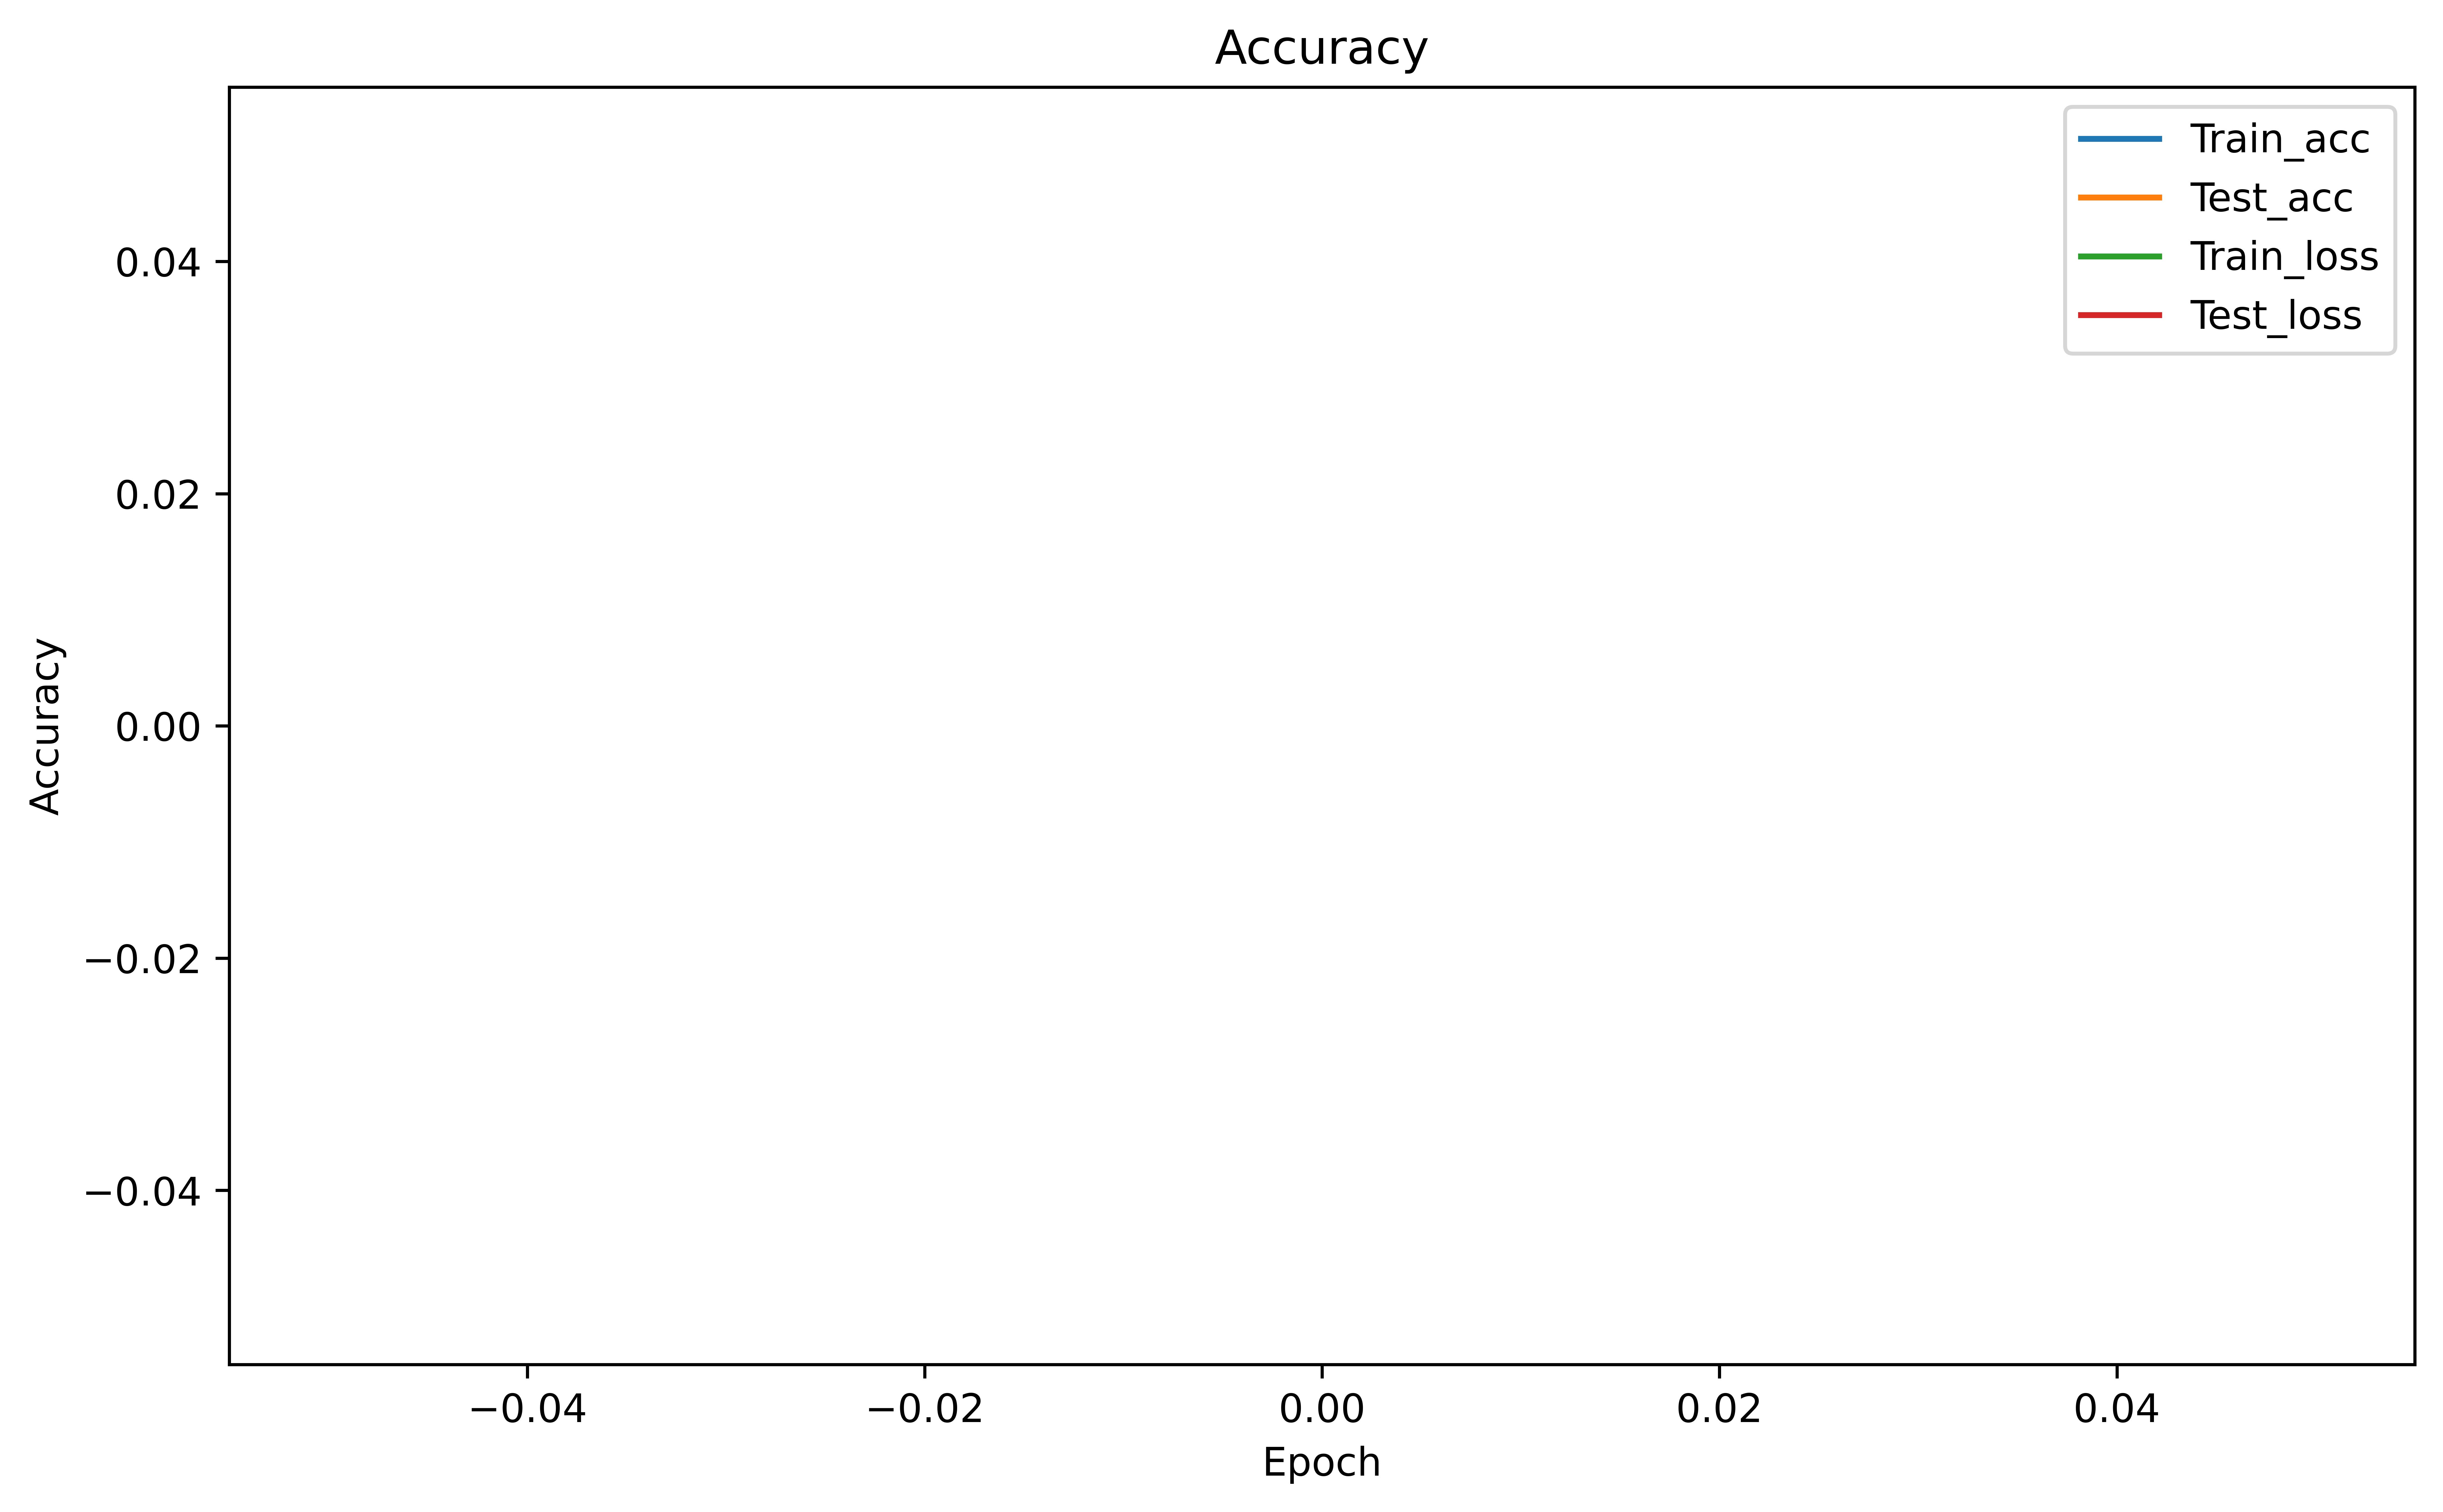

In [109]:
method = 'E-drop'
dataset = 'FMNIST'
exp_num = '11'
save = False
plot(method, dataset, exp_num, FMNIST_EPOCHS, train_loss_list, train_acc_list, test_loss_list, test_acc_list, save)

In [110]:
class Net_CIFAR10(nn.Module):
    def __init__(self, epsilon, switch):
        super().__init__()
        # Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.bn3 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 10)

        # Materials
        self.ldrop = lowdrop
        self.hdrop = highdrop
        self.jedrop = Jumping_Edrop
        self.EDrop = EDrop(epsilon, switch)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout(0.5)

    def forward(self, x, e):
        # [64, 3, 32, 32]

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.EDrop(x, e)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.EDrop(x, e)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        # x = x.view(-1, 64 * 8 * 8)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.EDrop(x, e)
        x = F.relu(x)
        x = self.fc2(x)
        return x



In [115]:
dataset = 'CIFAR-10'
CIFAR10_EPSILON = 0.5
CIFAR10_EPOCHS = 10
CIFAR10_SWITCH = CIFAR10_EPOCHS/2

model = Net_CIFAR10(CIFAR10_EPSILON, CIFAR10_SWITCH).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [116]:
# Run (CIFAR-10)
train_loss_list, train_acc_list, test_loss_list, test_acc_list = Run(dataset, model, optimizer, criterion, CIFAR10_EPOCHS, CIFAR10_EPSILON, CIFAR10_SWITCH)

Files already downloaded and verified
Files already downloaded and verified
Epoch  1 | Train Loss: 0.0168 | Train Accuracy: 0.6205 | Test Loss: 0.0138 | Test Accuracy: 0.6935
Epoch  2 | Train Loss: 0.0182 | Train Accuracy: 0.5994 | Test Loss: 0.0156 | Test Accuracy: 0.6496
Epoch  3 | Train Loss: 0.0137 | Train Accuracy: 0.6932 | Test Loss: 0.0139 | Test Accuracy: 0.6921
Epoch  4 | Train Loss: 0.0118 | Train Accuracy: 0.7351 | Test Loss: 0.0132 | Test Accuracy: 0.7095
Epoch  5 | Train Loss: 0.0100 | Train Accuracy: 0.7767 | Test Loss: 0.0128 | Test Accuracy: 0.7207
Epoch  6 | Train Loss: 0.0086 | Train Accuracy: 0.8099 | Test Loss: 0.0127 | Test Accuracy: 0.7243
Epoch  7 | Train Loss: 0.0070 | Train Accuracy: 0.8432 | Test Loss: 0.0123 | Test Accuracy: 0.7425
Epoch  8 | Train Loss: 0.0056 | Train Accuracy: 0.8762 | Test Loss: 0.0135 | Test Accuracy: 0.7305
Epoch  9 | Train Loss: 0.0045 | Train Accuracy: 0.9030 | Test Loss: 0.0143 | Test Accuracy: 0.7341
Epoch 10 | Train Loss: 0.0034 | T

In [113]:
# 1st Run (One low-drop after first conv)
# Epoch  1 | Train Loss: 0.0248 | Train Accuracy: 0.4558 | Test Loss: 0.0198 | Test Accuracy: 0.5539
# Epoch  2 | Train Loss: 0.0185 | Train Accuracy: 0.5805 | Test Loss: 0.0172 | Test Accuracy: 0.6208
# Epoch  3 | Train Loss: 0.0165 | Train Accuracy: 0.6296 | Test Loss: 0.0169 | Test Accuracy: 0.6209
# Epoch  4 | Train Loss: 0.0152 | Train Accuracy: 0.6575 | Test Loss: 0.0154 | Test Accuracy: 0.6571
# Epoch  5 | Train Loss: 0.0143 | Train Accuracy: 0.6795 | Test Loss: 0.0152 | Test Accuracy: 0.6676
# Epoch  6 | Train Loss: 0.0136 | Train Accuracy: 0.6974 | Test Loss: 0.0151 | Test Accuracy: 0.6646
# Epoch  7 | Train Loss: 0.0130 | Train Accuracy: 0.7112 | Test Loss: 0.0154 | Test Accuracy: 0.6644
# Epoch  8 | Train Loss: 0.0124 | Train Accuracy: 0.7219 | Test Loss: 0.0144 | Test Accuracy: 0.6891
# Epoch  9 | Train Loss: 0.0120 | Train Accuracy: 0.7312 | Test Loss: 0.0148 | Test Accuracy: 0.6756
# Epoch 10 | Train Loss: 0.0117 | Train Accuracy: 0.7404 | Test Loss: 0.0146 | Test Accuracy: 0.6866

# 2nd Run (Turn on 3 low-drop)
# Epoch  1 | Train Loss: 0.0196 | Train Accuracy: 0.5568 | Test Loss: 0.0162 | Test Accuracy: 0.6353
# Epoch  2 | Train Loss: 0.0139 | Train Accuracy: 0.6900 | Test Loss: 0.0145 | Test Accuracy: 0.6748
# Epoch  3 | Train Loss: 0.0112 | Train Accuracy: 0.7493 | Test Loss: 0.0134 | Test Accuracy: 0.7038
# Epoch  4 | Train Loss: 0.0091 | Train Accuracy: 0.7976 | Test Loss: 0.0134 | Test Accuracy: 0.7045
# Epoch  5 | Train Loss: 0.0073 | Train Accuracy: 0.8392 | Test Loss: 0.0142 | Test Accuracy: 0.7025
# Epoch  6 | Train Loss: 0.0059 | Train Accuracy: 0.8707 | Test Loss: 0.0141 | Test Accuracy: 0.7067
# Epoch  7 | Train Loss: 0.0046 | Train Accuracy: 0.9011 | Test Loss: 0.0149 | Test Accuracy: 0.7042
# Epoch  8 | Train Loss: 0.0039 | Train Accuracy: 0.9178 | Test Loss: 0.0158 | Test Accuracy: 0.7045
# Epoch  9 | Train Loss: 0.0032 | Train Accuracy: 0.9341 | Test Loss: 0.0164 | Test Accuracy: 0.7048
# Epoch 10 | Train Loss: 0.0026 | Train Accuracy: 0.9443 | Test Loss: 0.0170 | Test Accuracy: 0.7054

# 3rd Run (low drop)
# Epoch  1 | Train Loss: 0.0195 | Train Accuracy: 0.5603 | Test Loss: 0.0162 | Test Accuracy: 0.6395
# Epoch  2 | Train Loss: 0.0140 | Train Accuracy: 0.6872 | Test Loss: 0.0142 | Test Accuracy: 0.6825
# Epoch  3 | Train Loss: 0.0113 | Train Accuracy: 0.7499 | Test Loss: 0.0137 | Test Accuracy: 0.7002
# Epoch  4 | Train Loss: 0.0092 | Train Accuracy: 0.7956 | Test Loss: 0.0133 | Test Accuracy: 0.7107
# Epoch  5 | Train Loss: 0.0075 | Train Accuracy: 0.8340 | Test Loss: 0.0137 | Test Accuracy: 0.7074
# Epoch  6 | Train Loss: 0.0060 | Train Accuracy: 0.8689 | Test Loss: 0.0144 | Test Accuracy: 0.7055
# Epoch  7 | Train Loss: 0.0049 | Train Accuracy: 0.8934 | Test Loss: 0.0146 | Test Accuracy: 0.7082
# Epoch  8 | Train Loss: 0.0040 | Train Accuracy: 0.9150 | Test Loss: 0.0152 | Test Accuracy: 0.7080
# Epoch  9 | Train Loss: 0.0034 | Train Accuracy: 0.9271 | Test Loss: 0.0159 | Test Accuracy: 0.7083
# Epoch 10 | Train Loss: 0.0028 | Train Accuracy: 0.9424 | Test Loss: 0.0164 | Test Accuracy: 0.7134

# 4th Run (low drop epoch=100)
# Epoch  1 | Train Loss: 0.0196 | Train Accuracy: 0.5570 | Test Loss: 0.0159 | Test Accuracy: 0.6421
# Epoch  2 | Train Loss: 0.0141 | Train Accuracy: 0.6854 | Test Loss: 0.0144 | Test Accuracy: 0.6768
# Epoch  3 | Train Loss: 0.0114 | Train Accuracy: 0.7439 | Test Loss: 0.0139 | Test Accuracy: 0.6929
# Epoch  4 | Train Loss: 0.0094 | Train Accuracy: 0.7888 | Test Loss: 0.0138 | Test Accuracy: 0.7001
# Epoch  5 | Train Loss: 0.0076 | Train Accuracy: 0.8327 | Test Loss: 0.0136 | Test Accuracy: 0.7026
# Epoch  6 | Train Loss: 0.0062 | Train Accuracy: 0.8635 | Test Loss: 0.0143 | Test Accuracy: 0.7048
# Epoch  7 | Train Loss: 0.0049 | Train Accuracy: 0.8921 | Test Loss: 0.0150 | Test Accuracy: 0.6990
# Epoch  8 | Train Loss: 0.0040 | Train Accuracy: 0.9132 | Test Loss: 0.0156 | Test Accuracy: 0.6997
# Epoch  9 | Train Loss: 0.0034 | Train Accuracy: 0.9286 | Test Loss: 0.0164 | Test Accuracy: 0.7049
# Epoch 10 | Train Loss: 0.0029 | Train Accuracy: 0.9380 | Test Loss: 0.0168 | Test Accuracy: 0.7059
# Epoch 11 | Train Loss: 0.0025 | Train Accuracy: 0.9474 | Test Loss: 0.0175 | Test Accuracy: 0.6997
# Epoch 12 | Train Loss: 0.0022 | Train Accuracy: 0.9541 | Test Loss: 0.0181 | Test Accuracy: 0.6978
# Epoch 13 | Train Loss: 0.0020 | Train Accuracy: 0.9580 | Test Loss: 0.0188 | Test Accuracy: 0.6962
# Epoch 14 | Train Loss: 0.0018 | Train Accuracy: 0.9635 | Test Loss: 0.0196 | Test Accuracy: 0.6975
# Epoch 15 | Train Loss: 0.0017 | Train Accuracy: 0.9652 | Test Loss: 0.0200 | Test Accuracy: 0.6985
# Epoch 16 | Train Loss: 0.0015 | Train Accuracy: 0.9673 | Test Loss: 0.0201 | Test Accuracy: 0.6990
# Epoch 17 | Train Loss: 0.0015 | Train Accuracy: 0.9687 | Test Loss: 0.0207 | Test Accuracy: 0.6990
# Epoch 18 | Train Loss: 0.0013 | Train Accuracy: 0.9723 | Test Loss: 0.0211 | Test Accuracy: 0.6972
# Epoch 19 | Train Loss: 0.0013 | Train Accuracy: 0.9728 | Test Loss: 0.0210 | Test Accuracy: 0.7009
# Epoch 20 | Train Loss: 0.0012 | Train Accuracy: 0.9763 | Test Loss: 0.0211 | Test Accuracy: 0.7054
# Epoch 21 | Train Loss: 0.0013 | Train Accuracy: 0.9729 | Test Loss: 0.0214 | Test Accuracy: 0.7045
# Epoch 22 | Train Loss: 0.0011 | Train Accuracy: 0.9761 | Test Loss: 0.0214 | Test Accuracy: 0.7043
# Epoch 23 | Train Loss: 0.0010 | Train Accuracy: 0.9784 | Test Loss: 0.0221 | Test Accuracy: 0.6986
# Epoch 24 | Train Loss: 0.0010 | Train Accuracy: 0.9798 | Test Loss: 0.0226 | Test Accuracy: 0.6965
# Epoch 25 | Train Loss: 0.0010 | Train Accuracy: 0.9786 | Test Loss: 0.0230 | Test Accuracy: 0.6977
# ...
# Epoch 97 | Train Loss: 0.0003 | Train Accuracy: 0.9926 | Test Loss: 0.0327 | Test Accuracy: 0.6909
# Epoch 98 | Train Loss: 0.0003 | Train Accuracy: 0.9940 | Test Loss: 0.0317 | Test Accuracy: 0.6956
# Epoch 99 | Train Loss: 0.0002 | Train Accuracy: 0.9949 | Test Loss: 0.0324 | Test Accuracy: 0.6984
# Epoch 100 | Train Loss: 0.0003 | Train Accuracy: 0.9945 | Test Loss: 0.0324 | Test Accuracy: 0.6971

# 5th Run (high-drop, until 4th run: low-drop)
# Epoch  1 | Train Loss: 0.0172 | Train Accuracy: 0.6132 | Test Loss: 0.0140 | Test Accuracy: 0.6865
# Epoch  2 | Train Loss: 0.0111 | Train Accuracy: 0.7532 | Test Loss: 0.0123 | Test Accuracy: 0.7279
# Epoch  3 | Train Loss: 0.0079 | Train Accuracy: 0.8240 | Test Loss: 0.0119 | Test Accuracy: 0.7426
# Epoch  4 | Train Loss: 0.0054 | Train Accuracy: 0.8847 | Test Loss: 0.0124 | Test Accuracy: 0.7412
# Epoch  5 | Train Loss: 0.0035 | Train Accuracy: 0.9279 | Test Loss: 0.0134 | Test Accuracy: 0.7382
# Epoch  6 | Train Loss: 0.0023 | Train Accuracy: 0.9545 | Test Loss: 0.0145 | Test Accuracy: 0.7410
# Epoch  7 | Train Loss: 0.0017 | Train Accuracy: 0.9674 | Test Loss: 0.0159 | Test Accuracy: 0.7341
# Epoch  8 | Train Loss: 0.0014 | Train Accuracy: 0.9720 | Test Loss: 0.0163 | Test Accuracy: 0.7382
# Epoch  9 | Train Loss: 0.0011 | Train Accuracy: 0.9779 | Test Loss: 0.0169 | Test Accuracy: 0.7386
# Epoch 10 | Train Loss: 0.0010 | Train Accuracy: 0.9800 | Test Loss: 0.0180 | Test Accuracy: 0.7307


# 6th Run (Edrop, at the switch, it learn from the beginning again)
# Epoch  1 | Train Loss: 0.0182 | Train Accuracy: 0.5879 | Test Loss: 0.0155 | Test Accuracy: 0.6504
# Epoch  2 | Train Loss: 0.0134 | Train Accuracy: 0.6987 | Test Loss: 0.0140 | Test Accuracy: 0.6858
# Epoch  3 | Train Loss: 0.0110 | Train Accuracy: 0.7534 | Test Loss: 0.0126 | Test Accuracy: 0.7243
# Epoch  4 | Train Loss: 0.0090 | Train Accuracy: 0.8001 | Test Loss: 0.0126 | Test Accuracy: 0.7236
# Epoch  5 | Train Loss: 0.0072 | Train Accuracy: 0.8407 | Test Loss: 0.0133 | Test Accuracy: 0.7238
# Epoch  6 | Train Loss: 0.0055 | Train Accuracy: 0.8805 | Test Loss: 0.0134 | Test Accuracy: 0.7276
# Epoch  7 | Train Loss: 0.0041 | Train Accuracy: 0.9125 | Test Loss: 0.0140 | Test Accuracy: 0.7285
# Epoch  8 | Train Loss: 0.0031 | Train Accuracy: 0.9369 | Test Loss: 0.0152 | Test Accuracy: 0.7297
# Epoch  9 | Train Loss: 0.0023 | Train Accuracy: 0.9542 | Test Loss: 0.0159 | Test Accuracy: 0.7323
# Epoch 10 | Train Loss: 0.0018 | Train Accuracy: 0.9632 | Test Loss: 0.0170 | Test Accuracy: 0.7293
# Epoch 11 | Train Loss: 0.0197 | Train Accuracy: 0.5845 | Test Loss: 0.0156 | Test Accuracy: 0.6574
# Epoch 12 | Train Loss: 0.0127 | Train Accuracy: 0.7180 | Test Loss: 0.0136 | Test Accuracy: 0.7040
# Epoch 13 | Train Loss: 0.0101 | Train Accuracy: 0.7737 | Test Loss: 0.0130 | Test Accuracy: 0.7154
# Epoch 14 | Train Loss: 0.0080 | Train Accuracy: 0.8214 | Test Loss: 0.0129 | Test Accuracy: 0.7291
# Epoch 15 | Train Loss: 0.0063 | Train Accuracy: 0.8610 | Test Loss: 0.0132 | Test Accuracy: 0.7299
# Epoch 16 | Train Loss: 0.0047 | Train Accuracy: 0.8977 | Test Loss: 0.0138 | Test Accuracy: 0.7340
# Epoch 17 | Train Loss: 0.0036 | Train Accuracy: 0.9239 | Test Loss: 0.0146 | Test Accuracy: 0.7268
# Epoch 18 | Train Loss: 0.0026 | Train Accuracy: 0.9473 | Test Loss: 0.0154 | Test Accuracy: 0.7331
# Epoch 19 | Train Loss: 0.0021 | Train Accuracy: 0.9589 | Test Loss: 0.0162 | Test Accuracy: 0.7330
# Epoch 20 | Train Loss: 0.0017 | Train Accuracy: 0.9670 | Test Loss: 0.0169 | Test Accuracy: 0.7359
# Epoch 21 | Train Loss: 0.0013 | Train Accuracy: 0.9757 | Test Loss: 0.0181 | Test Accuracy: 0.7257
# Epoch 22 | Train Loss: 0.0013 | Train Accuracy: 0.9752 | Test Loss: 0.0186 | Test Accuracy: 0.7303
# Epoch 23 | Train Loss: 0.0011 | Train Accuracy: 0.9798 | Test Loss: 0.0194 | Test Accuracy: 0.7255
# Epoch 24 | Train Loss: 0.0009 | Train Accuracy: 0.9829 | Test Loss: 0.0201 | Test Accuracy: 0.7296
# Epoch 25 | Train Loss: 0.0009 | Train Accuracy: 0.9818 | Test Loss: 0.0201 | Test Accuracy: 0.7336
# ...
# Epoch 39 | Train Loss: 0.0004 | Train Accuracy: 0.9924 | Test Loss: 0.0257 | Test Accuracy: 0.7246
# Epoch 40 | Train Loss: 0.0004 | Train Accuracy: 0.9908 | Test Loss: 0.0258 | Test Accuracy: 0.7227
# Epoch 41 | Train Loss: 0.0005 | Train Accuracy: 0.9901 | Test Loss: 0.0254 | Test Accuracy: 0.7284
# Epoch 42 | Train Loss: 0.0004 | Train Accuracy: 0.9921 | Test Loss: 0.0249 | Test Accuracy: 0.7314

# E-drop 7 (switch every 10 epoch)
# Epoch  1 | Train Loss: 0.0183 | Train Accuracy: 0.5883 | Test Loss: 0.0159 | Test Accuracy: 0.6477
# Epoch  2 | Train Loss: 0.0140 | Train Accuracy: 0.6880 | Test Loss: 0.0143 | Test Accuracy: 0.6846
# Epoch  3 | Train Loss: 0.0118 | Train Accuracy: 0.7360 | Test Loss: 0.0134 | Test Accuracy: 0.7047
# Epoch  4 | Train Loss: 0.0099 | Train Accuracy: 0.7799 | Test Loss: 0.0131 | Test Accuracy: 0.7205
# Epoch  5 | Train Loss: 0.0082 | Train Accuracy: 0.8199 | Test Loss: 0.0132 | Test Accuracy: 0.7204
# Epoch  6 | Train Loss: 0.0064 | Train Accuracy: 0.8587 | Test Loss: 0.0134 | Test Accuracy: 0.7287
# Epoch  7 | Train Loss: 0.0050 | Train Accuracy: 0.8921 | Test Loss: 0.0139 | Test Accuracy: 0.7303
# Epoch  8 | Train Loss: 0.0038 | Train Accuracy: 0.9201 | Test Loss: 0.0151 | Test Accuracy: 0.7225
# Epoch  9 | Train Loss: 0.0029 | Train Accuracy: 0.9377 | Test Loss: 0.0163 | Test Accuracy: 0.7183
# Epoch 10 | Train Loss: 0.0023 | Train Accuracy: 0.9532 | Test Loss: 0.0172 | Test Accuracy: 0.7189
# Epoch 11 | Train Loss: 0.0200 | Train Accuracy: 0.5846 | Test Loss: 0.0157 | Test Accuracy: 0.6520
# Epoch 12 | Train Loss: 0.0132 | Train Accuracy: 0.7055 | Test Loss: 0.0146 | Test Accuracy: 0.6841
# Epoch 13 | Train Loss: 0.0108 | Train Accuracy: 0.7579 | Test Loss: 0.0136 | Test Accuracy: 0.7039
# Epoch 14 | Train Loss: 0.0088 | Train Accuracy: 0.8047 | Test Loss: 0.0133 | Test Accuracy: 0.7162
# Epoch 15 | Train Loss: 0.0071 | Train Accuracy: 0.8414 | Test Loss: 0.0129 | Test Accuracy: 0.7326
# Epoch 16 | Train Loss: 0.0056 | Train Accuracy: 0.8788 | Test Loss: 0.0138 | Test Accuracy: 0.7260
# Epoch 17 | Train Loss: 0.0044 | Train Accuracy: 0.9061 | Test Loss: 0.0143 | Test Accuracy: 0.7301
# Epoch 18 | Train Loss: 0.0034 | Train Accuracy: 0.9269 | Test Loss: 0.0149 | Test Accuracy: 0.7307
# Epoch 19 | Train Loss: 0.0026 | Train Accuracy: 0.9489 | Test Loss: 0.0159 | Test Accuracy: 0.7303
# Epoch 20 | Train Loss: 0.0020 | Train Accuracy: 0.9588 | Test Loss: 0.0168 | Test Accuracy: 0.7232
# Epoch 21 | Train Loss: 0.0155 | Train Accuracy: 0.7179 | Test Loss: 0.0148 | Test Accuracy: 0.7257
# Epoch 22 | Train Loss: 0.0058 | Train Accuracy: 0.8673 | Test Loss: 0.0144 | Test Accuracy: 0.7363
# Epoch 23 | Train Loss: 0.0034 | Train Accuracy: 0.9248 | Test Loss: 0.0152 | Test Accuracy: 0.7369
# Epoch 24 | Train Loss: 0.0024 | Train Accuracy: 0.9507 | Test Loss: 0.0167 | Test Accuracy: 0.7276
# Epoch 25 | Train Loss: 0.0017 | Train Accuracy: 0.9669 | Test Loss: 0.0171 | Test Accuracy: 0.7318
# ...
# Epoch 42 | Train Loss: 0.0015 | Train Accuracy: 0.9674 | Test Loss: 0.0200 | Test Accuracy: 0.7370
# Epoch 43 | Train Loss: 0.0009 | Train Accuracy: 0.9825 | Test Loss: 0.0205 | Test Accuracy: 0.7348
# Epoch 44 | Train Loss: 0.0007 | Train Accuracy: 0.9864 | Test Loss: 0.0215 | Test Accuracy: 0.7345
# Epoch 45 | Train Loss: 0.0008 | Train Accuracy: 0.9847 | Test Loss: 0.0238 | Test Accuracy: 0.7154

# Edrop 8th Run (high low high low high) (100 epoch)
# Epoch  1 | Train Loss: 0.0185 | Train Accuracy: 0.5832 | Test Loss: 0.0159 | Test Accuracy: 0.6431
# Epoch  2 | Train Loss: 0.0141 | Train Accuracy: 0.6831 | Test Loss: 0.0144 | Test Accuracy: 0.6825
# Epoch  3 | Train Loss: 0.0119 | Train Accuracy: 0.7345 | Test Loss: 0.0134 | Test Accuracy: 0.6990
# Epoch  4 | Train Loss: 0.0100 | Train Accuracy: 0.7784 | Test Loss: 0.0132 | Test Accuracy: 0.7097
# Epoch  5 | Train Loss: 0.0082 | Train Accuracy: 0.8171 | Test Loss: 0.0132 | Test Accuracy: 0.7246
# Epoch  6 | Train Loss: 0.0066 | Train Accuracy: 0.8544 | Test Loss: 0.0133 | Test Accuracy: 0.7283
# Epoch  7 | Train Loss: 0.0051 | Train Accuracy: 0.8881 | Test Loss: 0.0140 | Test Accuracy: 0.7272
# Epoch  8 | Train Loss: 0.0040 | Train Accuracy: 0.9155 | Test Loss: 0.0146 | Test Accuracy: 0.7295
# Epoch  9 | Train Loss: 0.0030 | Train Accuracy: 0.9357 | Test Loss: 0.0155 | Test Accuracy: 0.7243
# Epoch 10 | Train Loss: 0.0023 | Train Accuracy: 0.9530 | Test Loss: 0.0169 | Test Accuracy: 0.7221
# Epoch 11 | Train Loss: 0.0019 | Train Accuracy: 0.9607 | Test Loss: 0.0180 | Test Accuracy: 0.7260
# Epoch 12 | Train Loss: 0.0017 | Train Accuracy: 0.9656 | Test Loss: 0.0195 | Test Accuracy: 0.7181
# Epoch 13 | Train Loss: 0.0014 | Train Accuracy: 0.9713 | Test Loss: 0.0200 | Test Accuracy: 0.7148
# Epoch 14 | Train Loss: 0.0013 | Train Accuracy: 0.9729 | Test Loss: 0.0205 | Test Accuracy: 0.7159
# Epoch 15 | Train Loss: 0.0011 | Train Accuracy: 0.9777 | Test Loss: 0.0213 | Test Accuracy: 0.7184
# Epoch 16 | Train Loss: 0.0009 | Train Accuracy: 0.9810 | Test Loss: 0.0220 | Test Accuracy: 0.7202
# Epoch 17 | Train Loss: 0.0010 | Train Accuracy: 0.9791 | Test Loss: 0.0225 | Test Accuracy: 0.7181
# Epoch 18 | Train Loss: 0.0009 | Train Accuracy: 0.9806 | Test Loss: 0.0226 | Test Accuracy: 0.7235
# Epoch 19 | Train Loss: 0.0007 | Train Accuracy: 0.9849 | Test Loss: 0.0230 | Test Accuracy: 0.7247
# Epoch 20 | Train Loss: 0.0008 | Train Accuracy: 0.9832 | Test Loss: 0.0238 | Test Accuracy: 0.7179
# Epoch 21 | Train Loss: 0.0231 | Train Accuracy: 0.5563 | Test Loss: 0.0172 | Test Accuracy: 0.6252
# Epoch 22 | Train Loss: 0.0151 | Train Accuracy: 0.6656 | Test Loss: 0.0160 | Test Accuracy: 0.6548
# Epoch 23 | Train Loss: 0.0132 | Train Accuracy: 0.7095 | Test Loss: 0.0154 | Test Accuracy: 0.6716
# Epoch 24 | Train Loss: 0.0114 | Train Accuracy: 0.7464 | Test Loss: 0.0147 | Test Accuracy: 0.6903
# Epoch 25 | Train Loss: 0.0099 | Train Accuracy: 0.7775 | Test Loss: 0.0143 | Test Accuracy: 0.7058
# ...
# Epoch 97 | Train Loss: 0.0004 | Train Accuracy: 0.9918 | Test Loss: 0.0301 | Test Accuracy: 0.7281
# Epoch 98 | Train Loss: 0.0003 | Train Accuracy: 0.9936 | Test Loss: 0.0296 | Test Accuracy: 0.7329
# Epoch 99 | Train Loss: 0.0003 | Train Accuracy: 0.9934 | Test Loss: 0.0300 | Test Accuracy: 0.7326
# Epoch 100 | Train Loss: 0.0003 | Train Accuracy: 0.9928 | Test Loss: 0.0301 | Test Accuracy: 0.7295

# Edrop 9th Run (low high low high low) (100 epoch)
# Epoch  1 | Train Loss: 0.0168 | Train Accuracy: 0.6189 | Test Loss: 0.0135 | Test Accuracy: 0.6991
# Epoch  2 | Train Loss: 0.0113 | Train Accuracy: 0.7459 | Test Loss: 0.0120 | Test Accuracy: 0.7346
# Epoch  3 | Train Loss: 0.0085 | Train Accuracy: 0.8128 | Test Loss: 0.0119 | Test Accuracy: 0.7380
# Epoch  4 | Train Loss: 0.0062 | Train Accuracy: 0.8669 | Test Loss: 0.0121 | Test Accuracy: 0.7476
# Epoch  5 | Train Loss: 0.0043 | Train Accuracy: 0.9105 | Test Loss: 0.0128 | Test Accuracy: 0.7427
# Epoch  6 | Train Loss: 0.0029 | Train Accuracy: 0.9407 | Test Loss: 0.0140 | Test Accuracy: 0.7409
# Epoch  7 | Train Loss: 0.0021 | Train Accuracy: 0.9599 | Test Loss: 0.0148 | Test Accuracy: 0.7343
# Epoch  8 | Train Loss: 0.0015 | Train Accuracy: 0.9708 | Test Loss: 0.0157 | Test Accuracy: 0.7401
# Epoch  9 | Train Loss: 0.0013 | Train Accuracy: 0.9734 | Test Loss: 0.0172 | Test Accuracy: 0.7337
# Epoch 10 | Train Loss: 0.0011 | Train Accuracy: 0.9777 | Test Loss: 0.0173 | Test Accuracy: 0.7413
# Epoch 11 | Train Loss: 0.0010 | Train Accuracy: 0.9819 | Test Loss: 0.0182 | Test Accuracy: 0.7381
# Epoch 12 | Train Loss: 0.0009 | Train Accuracy: 0.9818 | Test Loss: 0.0189 | Test Accuracy: 0.7333
# Epoch 13 | Train Loss: 0.0009 | Train Accuracy: 0.9810 | Test Loss: 0.0189 | Test Accuracy: 0.7445
# Epoch 14 | Train Loss: 0.0008 | Train Accuracy: 0.9840 | Test Loss: 0.0195 | Test Accuracy: 0.7393
# Epoch 15 | Train Loss: 0.0007 | Train Accuracy: 0.9859 | Test Loss: 0.0196 | Test Accuracy: 0.7431
# Epoch 16 | Train Loss: 0.0006 | Train Accuracy: 0.9872 | Test Loss: 0.0202 | Test Accuracy: 0.7380
# Epoch 17 | Train Loss: 0.0006 | Train Accuracy: 0.9889 | Test Loss: 0.0203 | Test Accuracy: 0.7430
# Epoch 18 | Train Loss: 0.0006 | Train Accuracy: 0.9884 | Test Loss: 0.0205 | Test Accuracy: 0.7434
# Epoch 19 | Train Loss: 0.0005 | Train Accuracy: 0.9897 | Test Loss: 0.0209 | Test Accuracy: 0.7438
# Epoch 20 | Train Loss: 0.0005 | Train Accuracy: 0.9892 | Test Loss: 0.0220 | Test Accuracy: 0.7353
# Epoch 21 | Train Loss: 0.0259 | Train Accuracy: 0.5469 | Test Loss: 0.0178 | Test Accuracy: 0.6176
# Epoch 22 | Train Loss: 0.0164 | Train Accuracy: 0.6435 | Test Loss: 0.0167 | Test Accuracy: 0.6399
# Epoch 23 | Train Loss: 0.0148 | Train Accuracy: 0.6774 | Test Loss: 0.0163 | Test Accuracy: 0.6503
# Epoch 24 | Train Loss: 0.0136 | Train Accuracy: 0.7031 | Test Loss: 0.0159 | Test Accuracy: 0.6646
# Epoch 25 | Train Loss: 0.0124 | Train Accuracy: 0.7271 | Test Loss: 0.0160 | Test Accuracy: 0.6556
# ...
# Epoch 97 | Train Loss: 0.0002 | Train Accuracy: 0.9956 | Test Loss: 0.0261 | Test Accuracy: 0.7412
# Epoch 98 | Train Loss: 0.0002 | Train Accuracy: 0.9960 | Test Loss: 0.0271 | Test Accuracy: 0.7371
# Epoch 99 | Train Loss: 0.0003 | Train Accuracy: 0.9948 | Test Loss: 0.0267 | Test Accuracy: 0.7480
# Epoch 100 | Train Loss: 0.0003 | Train Accuracy: 0.9944 | Test Loss: 0.0272 | Test Accuracy: 0.7444

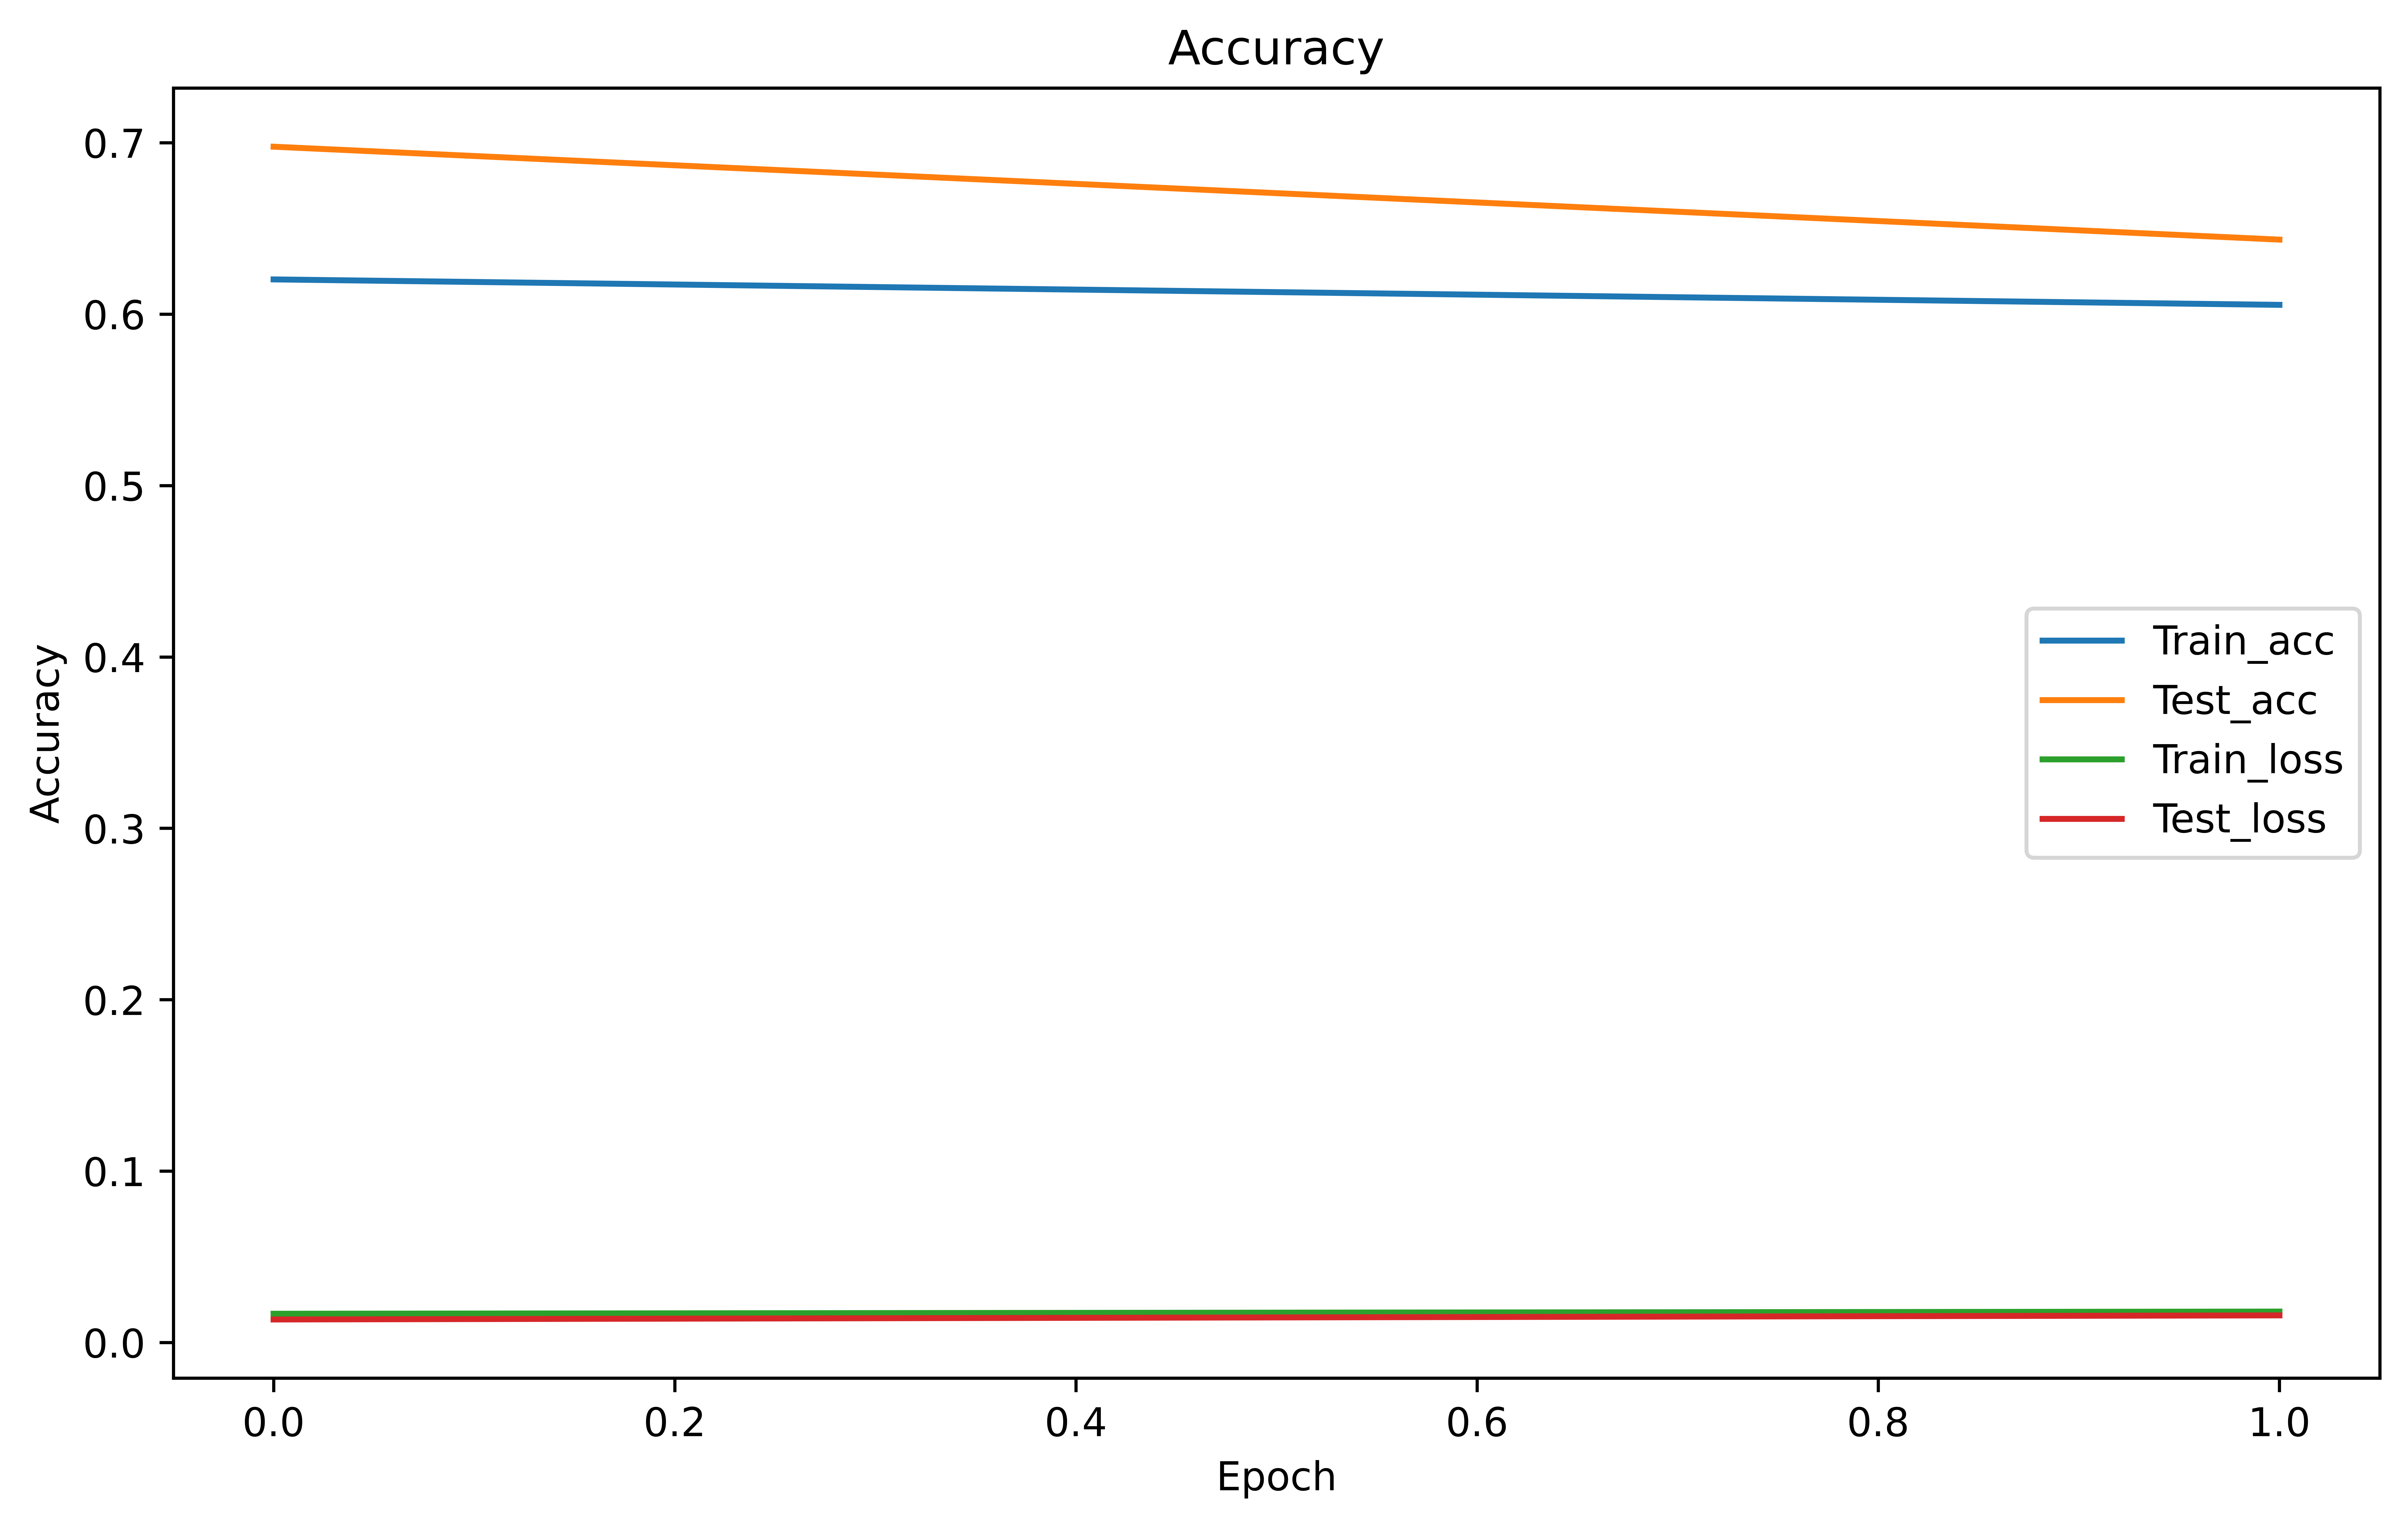

In [114]:
method = 'E-drop'
dataset = 'CIFAR-10'
exp_num = '11'
save = False
plot(method, dataset, exp_num, CIFAR10_EPOCHS, train_loss_list, train_acc_list, test_loss_list, test_acc_list, save)